In [43]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import pandas as pd
from src.gpt_prompt import get_sentiment_general, get_sentiment_general_parallel, get_risk_score
import datetime

In [44]:
df_news = pd.read_csv("../data/news_apple_2022.csv", index_col=0)
df_price = pd.read_csv("../data/price_apple_2022.csv", index_col=0)
df_news["date"] = pd.to_datetime(df_news['date'])
df_price["date"] = pd.to_datetime(df_price['date'])
print(df_news.head())
print(df_price.head())

                 date                                               news
0 2022-01-01 00:32:44  I actually lost weight this holiday season — t...
1 2022-01-01 00:52:34  January Dogs Of The Dow Need A PullbackThirty-...
2 2022-01-01 01:04:02  I switched from Android to iPhone — here's wha...
3 2022-01-01 01:36:26  365 Inspirational Quotes for 2022Inspiring, po...
4 2022-01-01 02:06:21  Is Fitbit Premium worth it? Here's the pros an...
                 date       price
0 2022-01-03 09:31:00  175.826576
1 2022-01-03 09:32:00  176.596792
2 2022-01-03 09:33:00  176.636290
3 2022-01-03 09:34:00  176.776509
4 2022-01-03 09:35:00  176.705412


In [45]:
df_score = pd.read_csv("../data/news_risk_apple_2022_3.csv", index_col=0)
df_score = df_score[["date", "score"]]
df_score["date"] = pd.to_datetime(df_score['date'])

In [46]:
df_score

,date,score
0,2022-01-01 01:36:26,20
1,2022-01-02 02:05:27,20
2,2022-01-03 06:28:26,25
3,2022-01-03 10:22:45,78
4,2022-01-03 13:54:16,20
...,...,...
1091,2022-12-29 12:15:30,85
1092,2022-12-29 17:26:19,65
1093,2022-12-30 07:06:12,72
1094,2022-12-30 17:00:58,65


In [47]:
date_price_dict = df_price.set_index('date')['price'].to_dict()
# date_price_dict

In [48]:
def find_whole_minute_time_after_n_minutes(time, n):
    new_time = time + pd.Timedelta(minutes=n)
    if new_time.second > 0:
        new_time += pd.Timedelta(minutes=1)
        new_time = new_time.replace(second=0, microsecond=0)
    return new_time

In [49]:
df_news.shape

(43832, 2)

In [50]:

columns = ["price_now", "price_in5", "price_in10", "price_in30", "price_in60"]
deltas = [0, 5, 10, 30, 60]
pd_price = np.zeros((df_news.shape[0], 5))

for i in range(df_news.shape[0]):
    time = df_news["date"][i]
    for j in range(5):
        delta = deltas[j]
        new_time = find_whole_minute_time_after_n_minutes(time, delta)
        if new_time in date_price_dict:
            pd_price[i, j] = date_price_dict[new_time]

In [51]:
pd_price = pd.DataFrame(pd_price, columns=columns)
result_df = pd.concat([df_news, pd_price], axis=1)

In [52]:
result_df.replace(0, pd.NA, inplace=True)
result_df = result_df.merge(df_score, on='date', how='left')
result_df["score"] = result_df["score"].astype(float)
result_df = result_df.dropna()



return_cols = ["return_in5", "return_in10", "return_in20", "return_in60"]
price_cols = ["price_in5", "price_in10", "price_in30", "price_in60"]

for i in range(4):
    result_df[return_cols[i]] = (result_df[price_cols[i]] - result_df["price_now"]) / result_df["price_now"]
    result_df[return_cols[i]] = result_df[return_cols[i]].astype(float)
for col in price_cols:
    result_df.drop(col, axis=1, inplace=True)
result_df

,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
123,2022-01-03 10:22:45,Water Ways Technologies Strengthens its Board ...,178.349528,78.0,0.001966,0.001301,0.002575,0.002962
163,2022-01-03 13:54:16,Apple becomes first U.S. company to reach $3 t...,180.230633,20.0,-0.000877,-0.001425,-0.003726,-0.002465
403,2022-01-04 10:49:28,Don't get overexposed to Tesla and Apple - inv...,179.8554,70.0,-0.000933,-0.006149,-0.009498,-0.011639
443,2022-01-04 12:53:38,"Stocks making the biggest moves midday: Ford, ...",177.09052,85.0,-0.000335,0.000781,0.001059,0.001673
603,2022-01-05 11:44:24,Rare price drop has Apple's 30W USB-C Power Ad...,176.389426,25.0,0.000756,0.001400,0.001847,-0.000448
...,...,...,...,...,...,...,...,...
42923,2022-12-21 11:13:34,The Best EV Stocks to Buy to Dethrone Tesla in...,135.252328,85.0,-0.000367,-0.003194,-0.003892,-0.006462
43043,2022-12-22 10:42:41,Now There AreOne-Stop Shops to Launch Your ETF...,130.718425,78.0,0.000646,0.002051,0.000570,-0.002051
43363,2022-12-27 11:48:19,More developers reportedly now use Linux than ...,129.257519,65.0,-0.000769,0.000385,0.001539,-0.001846
43483,2022-12-28 12:01:57,RSI Alert: Apple Now OversoldBut making Apple ...,126.115084,75.0,-0.000552,-0.001340,0.000276,0.007452


In [53]:
result_df = result_df.dropna()

In [54]:
result_df.describe(include='all')

/var/folders/v0/_fszh3l96cz8c79p9psn63y80000gn/T/ipykernel_16707/3235814888.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result_df.describe(include='all')


,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
count,350,350,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
unique,350,349,349.000000,NaN,NaN,NaN,NaN,NaN
top,2022-01-03 10:22:45,Apple Inc. (AAPL) is Attracting Investor Atten...,175.467251,NaN,NaN,NaN,NaN,NaN
freq,1,2,2.000000,NaN,NaN,NaN,NaN,NaN
first,2022-01-03 10:22:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-12-29 12:15:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,59.628571,-0.000010,0.000078,0.000004,-0.000439
std,NaN,NaN,NaN,25.803296,0.002112,0.002887,0.004900,0.006247
min,NaN,NaN,NaN,10.000000,-0.007605,-0.014603,-0.022671,-0.022551
25%,NaN,NaN,NaN,35.000000,-0.001177,-0.001533,-0.002548,-0.003998


In [55]:
result_df.dtypes

date           datetime64[ns]
news                   object
price_now              object
score                 float64
return_in5            float64
return_in10           float64
return_in20           float64
return_in60           float64
dtype: object

In [56]:
correlation_matrix = result_df[["score", 'return_in5', 'return_in10', 'return_in20', 'return_in60']].corr()

In [57]:
correlation_matrix

,score,return_in5,return_in10,return_in20,return_in60
score,1.000000,-0.032600,-0.030330,0.032108,0.007331
return_in5,-0.032600,1.000000,0.697434,0.359243,0.385587
return_in10,-0.030330,0.697434,1.000000,0.561337,0.495269
return_in20,0.032108,0.359243,0.561337,1.000000,0.711790
return_in60,0.007331,0.385587,0.495269,0.711790,1.000000


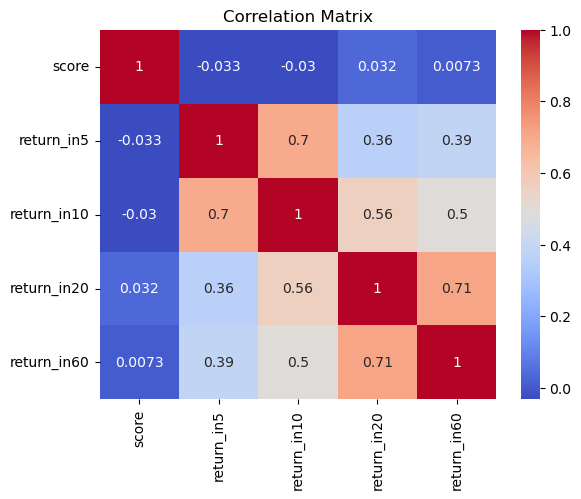

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

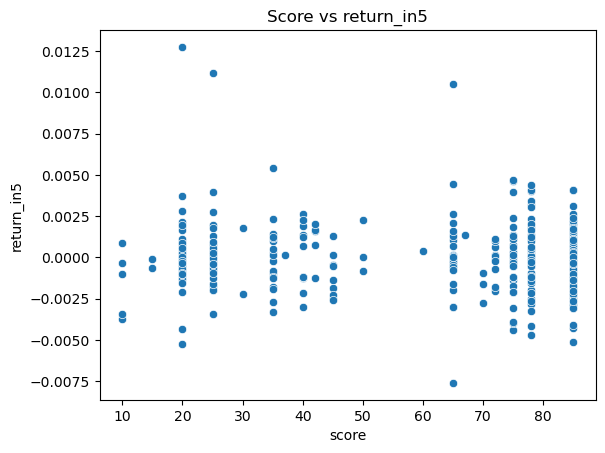

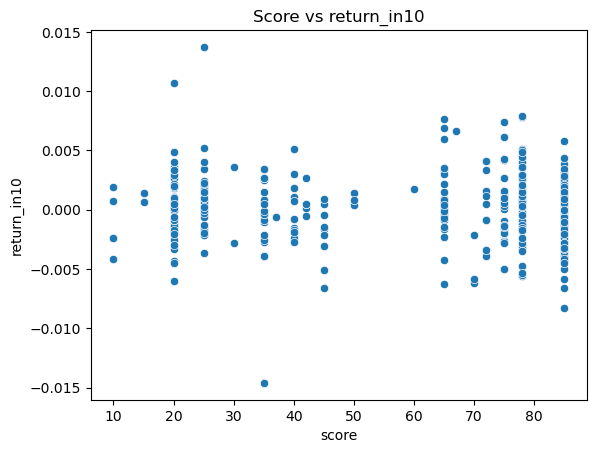

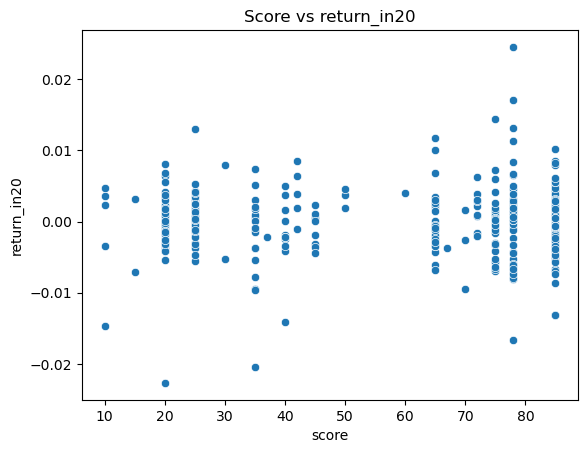

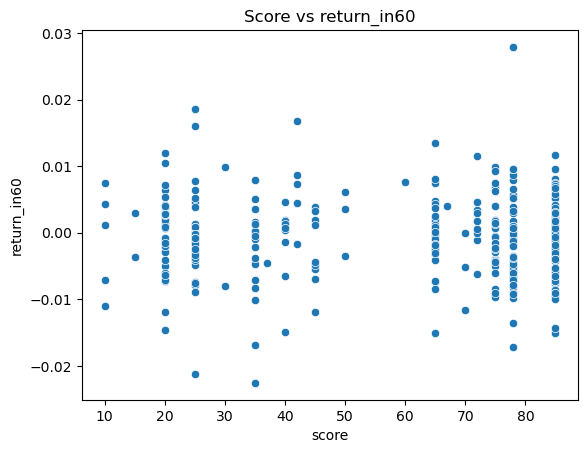

In [59]:
for return_col in ['return_in5', 'return_in10', 'return_in20', 'return_in60']:
    sns.scatterplot(x='score', y=return_col, data=result_df)
    plt.title(f'Score vs {return_col}')
    plt.show()

In [60]:
np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]]).shape

(350, 4)

In [61]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = np.array(result_df["score"]).reshape(-1,1)
y = np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]])
lr.fit(X, y)

LinearRegression()

In [62]:
lr.coef_

array([[-2.66879254e-06],
       [-3.39375520e-06],
       [ 6.09683944e-06],
       [ 1.77468155e-06]])